In [53]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter 
from skimage.morphology import remove_small_objects, closing, square


In [34]:

# Step 1: Read the Raster Image
raster_path = r"C:\Users\TyHow\MinersAI Dropbox\Product\Pilot Projects\Chile - Mantos Grandes\Geology\archivo_geologia-de-los-cuadrangulos-d-86-las-ramadas-carrizal-y-paso-rio-negro-region-de-coquimbo\MAP1\Georeferencing\Finalized_Items\MAP1_GR_FINAL.tif"  # Replace with your raster file path

with rasterio.open(raster_path) as src:
    # Read all bands into a 3D NumPy array (bands, rows, columns)
    raster_data = src.read()
    # Convert to float to handle NaNs
    raster_data = raster_data.astype('float32')  # Convert to float to allow NaN values
    # Get metadata
    transform = src.transform
    crs = src.crs


In [35]:

# Step 2: Prepare the Data for Clustering
# Reshape the raster data to a 2D array where each pixel is a row
# If the raster has multiple bands, we preserve them for clustering

# Define a threshold to identify black pixels
black_threshold = 10  # Adjust this value as needed for your specific image

# Create a mask for black pixels
if raster_data.shape[0] > 1:  # Multi-band (e.g., RGB) image
    black_mask = np.all(raster_data <= black_threshold, axis=0)
else:  # Single-band image
    black_mask = raster_data[0] <= black_threshold\

# Set black pixels to NaN
raster_data[:, black_mask] = -1


n_bands, n_rows, n_cols = raster_data.shape
reshaped_data = raster_data.reshape((n_bands, n_rows * n_cols)).T


In [49]:

# Step 3: Run K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=31)
kmeans.fit(reshaped_data)

# Get the cluster labels for each pixel
clustered = kmeans.labels_


In [50]:

# Step 4: Reshape the clustered result back to the original raster shape
clustered_image = clustered.reshape((n_rows, n_cols))


In [64]:
# Step 7: Convert NaNs to Zero for Morphological Operations
smoothed_image_cleaned = np.nan_to_num(clustered_image, nan=0)

# Step 8: Apply Morphological Closing to Connect Grid Lines
# Use a square structuring element to help close the gaps
closed_image = closing(smoothed_image_cleaned, square(10))  # Use square(6) to connect gaps up to 6 pixels wide

# Step 9: Remove Small Objects
# Convert to integer type for remove_small_objects
closed_image = closed_image.astype(int)

# Use remove_small_objects to filter out elements smaller than a larger threshold
filtered_image = remove_small_objects(closed_image, min_size=30)  # Adjust min_size as ne

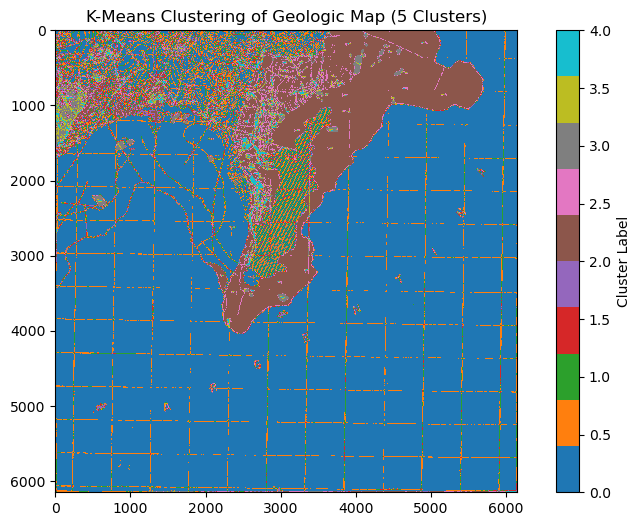

In [65]:

# Step 5: Visualize the Clustering Result
plt.figure(figsize=(10, 6))
plt.imshow(filtered_image, cmap='tab10')
plt.title('K-Means Clustering of Geologic Map (5 Clusters)')
plt.colorbar(label='Cluster Label')
plt.show()
